In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Synthetic core and lithosphere with tapered ensembles as prior"
nb_name = "nb_case_separation_synthetic"

# Lithosphere

In [2]:
shc_g = 30
shc_grid = 30

lith = SDSS(comment, N_SH = shc_g, sim_type = "lith_ens", sat_height = 350)

lith.grid_glq(nmax = shc_grid, r_at = lith.a)

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = False)
lith.generate_map()

lith.condtab(normsize=10000, quantiles = 1000, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"



All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


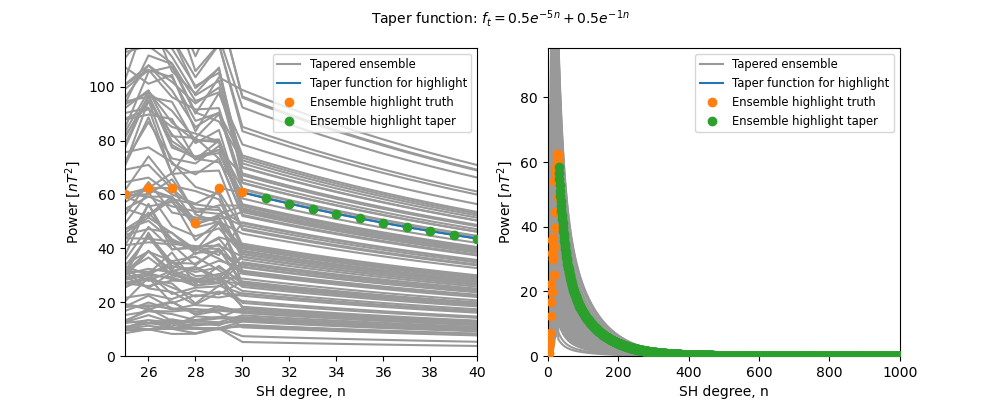

In [58]:
lith.cov_model_taper(r_at = lith.a, tap_to = 2000, tap_exp_p1 = 5, tap_exp_p2 = 1,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
                     save_fig = False, save_string = "case_lith_synthetic", save_dpi = 300)

#lith.cov_model_taper(r_at = lith.a, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
#                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
#                     save_fig = False, save_string = "case_lith_synthetic", save_dpi = 300)

#lith.cov_model(r_at = lith.a)

In [4]:
shc_g = 30
shc_grid = 30

lith_truth = SDSS(comment, N_SH = shc_g, sim_type = "surface", sat_height = 350, N_SH_secondary = None)
lith_truth.grid_glq(nmax = shc_grid, r_at = lith_truth.a)
grid_in = np.array([lith_truth.grid_phi, 90-lith_truth.grid_theta]).T
lith_truth.make_grid(lith_truth.a, grid_in, calc_sph_d = False)
lith_truth.generate_map()

# Core

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


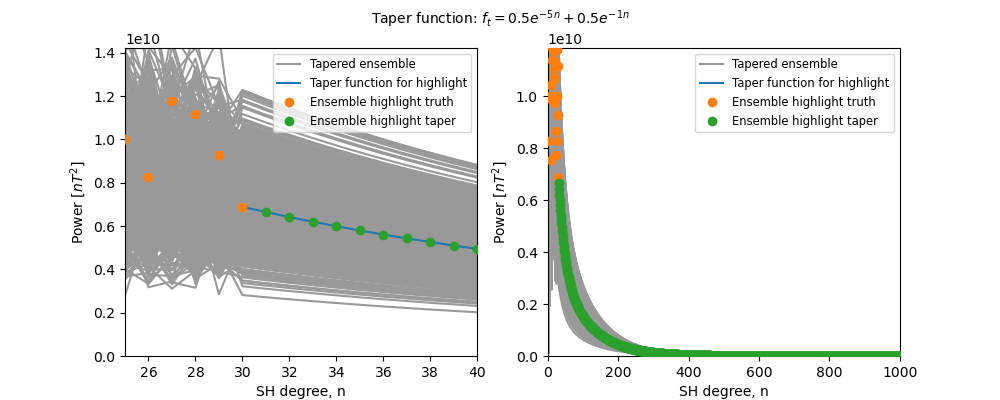

In [59]:
core.cov_model_taper(r_at = core.r_cmb, tap_to = 2000, tap_exp_p1 = 5, tap_exp_p2 = 1,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
                     save_fig = False, save_string = "case_core_synthetic", save_dpi = 300)


All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


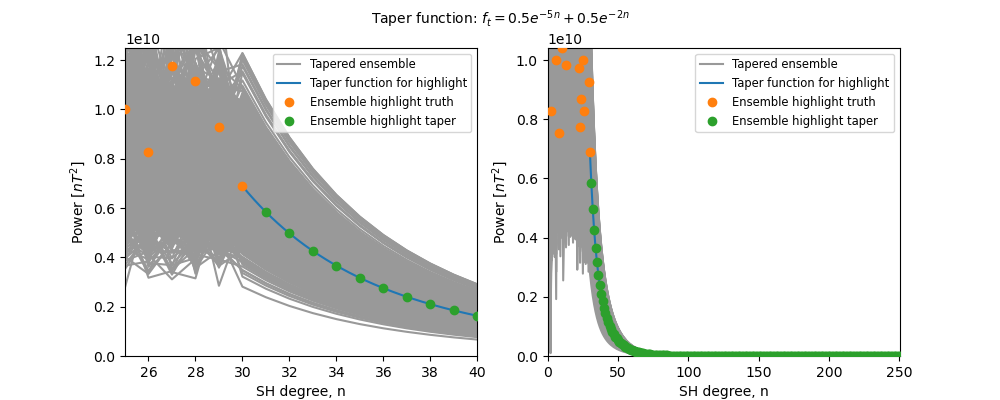

In [5]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

core.condtab(normsize=10000, quantiles = 1000, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble")

core.cov_model_taper(r_at = core.r_cmb, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
                     save_fig = False, save_string = "case_core_synthetic", save_dpi = 300)

#core.cov_model_taper(r_at = core.r_cmb, tap_to = 2000, tap_exp_p1 = 5, tap_exp_p2 = 1,
#                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
#                     save_fig = False, save_string = "case_core_synthetic", save_dpi = 300)

In [6]:
shc_g = 30
shc_grid = 30

core_truth = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)
core_truth.grid_glq(nmax = shc_grid, r_at = core_truth.r_cmb)
grid_in = np.array([core_truth.grid_phi, 90-core_truth.grid_theta]).T
core_truth.make_grid(core_truth.r_cmb, grid_in, calc_sph_d = False)
core_truth.generate_map()

# Synthetic observations

In [7]:
C_e_const = 2
s_sat = SDSS(comment, N_SH = shc_g, sim_type = "separation", sat_height = 350, N_SH_secondary = shc_g)
s_sat.load_swarm("A")
grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)
s_sat.generate_map(grid_type = "swarm")
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Forward operators

In [8]:
#C_e_const = 1.0

lith.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = lith.C_ens_tap)
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

In [9]:
G = np.hstack((core.G,lith.G))

In [10]:
obs = s_sat.data.reshape(-1,1)

In [11]:
m0 = np.hstack((np.mean(core.m_ens,axis=1),np.mean(lith.m_ens,axis=1))).reshape(-1,1)

In [12]:
C_M = np.zeros((G.shape[1],G.shape[1]))

C_M[:core.C_mm_all.shape[0],:core.C_mm_all.shape[0]] = core.C_mm_all
C_M[-lith.C_mm_all.shape[0]:,-lith.C_mm_all.shape[0]:] = lith.C_mm_all

C_D = np.diag(C_e_const**2*np.ones(s_sat.grid_N,)) #+ core.C_dd #+ lith.C_dd

In [13]:
S = C_D + G@C_M@G.T
T = np.linalg.inv(S)
m_equiv_lsq = C_M@G.T@T@obs #m0 + (obs-G@m0)

In [14]:
lsq_equiv_pred = G@m_equiv_lsq
lsq_equiv_res = obs - lsq_equiv_pred

<IPython.core.display.Javascript object>


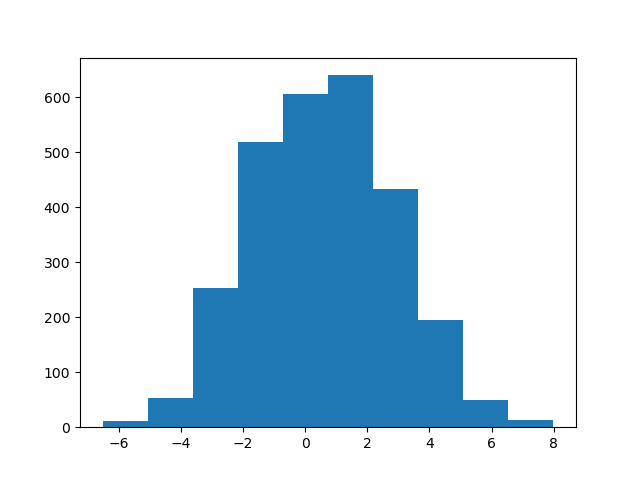

In [15]:
plt.figure()
plt.hist(lsq_equiv_res)
plt.show()

In [53]:
set_nmax_core = 30
set_nmax_lith = 30

core.grid_glq(nmax = set_nmax_core, r_at = core.r_cmb)
lith.grid_glq(nmax = set_nmax_lith, r_at = lith.a)

g_lsq_core, _ = mt_util.sh_expand_glq(m_equiv_lsq[:core.grid_N], core.grid_nmax, core.grid_w_shtools, 
                                      core.grid_zero, set_nmax_core, geomag_r_at = core.r_cmb)

g_lsq_lith, _ = mt_util.sh_expand_glq(m_equiv_lsq[core.grid_N:], lith.grid_nmax, lith.grid_w_shtools, 
                                      lith.grid_zero, set_nmax_lith, geomag_r_at = lith.a)

In [54]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(g_lsq_core, nmax = set_nmax_core, r_at = core.r_cmb, grid_type = "glq")
m_lsq_core = core.B_ensemble[:,0].copy()

lith.grid_glq(nmax = 256, r_at = lith.a)
lith.ensemble_B(g_lsq_lith, nmax = set_nmax_lith, r_at = lith.a, grid_type = "glq")
m_lsq_lith = lith.B_ensemble[:,0].copy()

core_truth.grid_glq(nmax = 256, r_at = core_truth.r_cmb)
core_truth.ensemble_B(core_truth.g_prior, nmax = set_nmax_core, r_at = core_truth.r_cmb, grid_type = "glq")
m_core_truth = core_truth.B_ensemble[:,0].copy()

lith_truth.grid_glq(nmax = 256, r_at = lith_truth.r_cmb)
lith_truth.ensemble_B(lith_truth.g_prior, nmax = set_nmax_lith, r_at = lith_truth.a, grid_type = "glq")
m_lith_truth = lith_truth.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


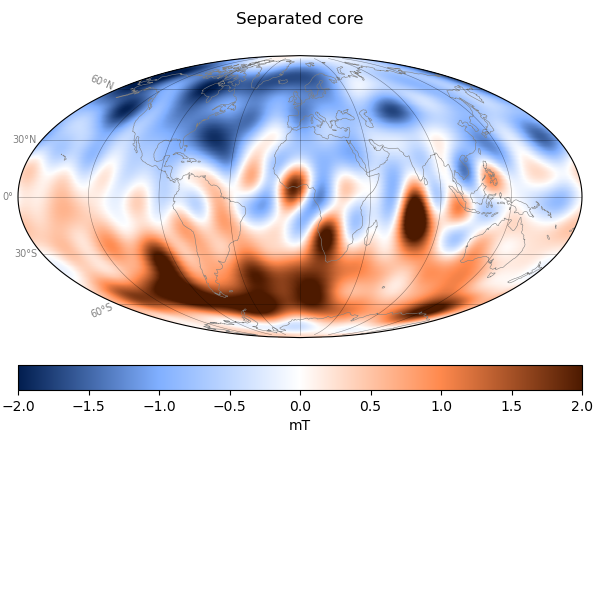

<IPython.core.display.Javascript object>


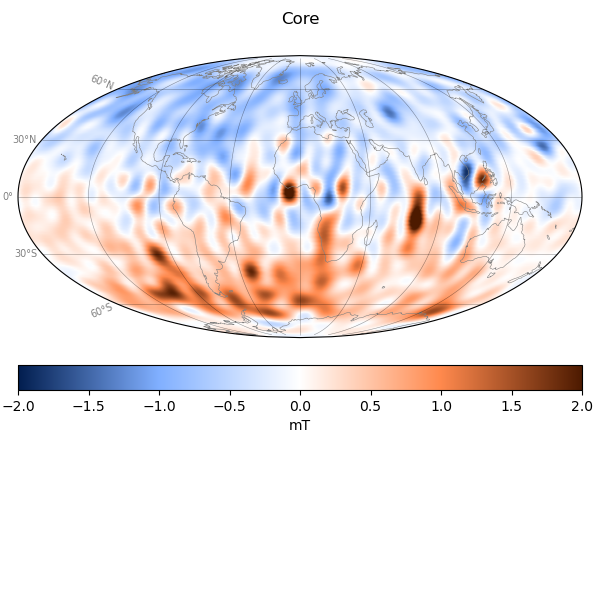

In [55]:
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=m_lsq_core, limits_data = [-2,2],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Separated core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_core",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=m_core_truth, limits_data = [-2,2],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_core",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.grid_glq(nmax = set_nmax_core, r_at = core.r_cmb)
core_truth.grid_glq(nmax = set_nmax_core, r_at = core_truth.r_cmb)

<IPython.core.display.Javascript object>


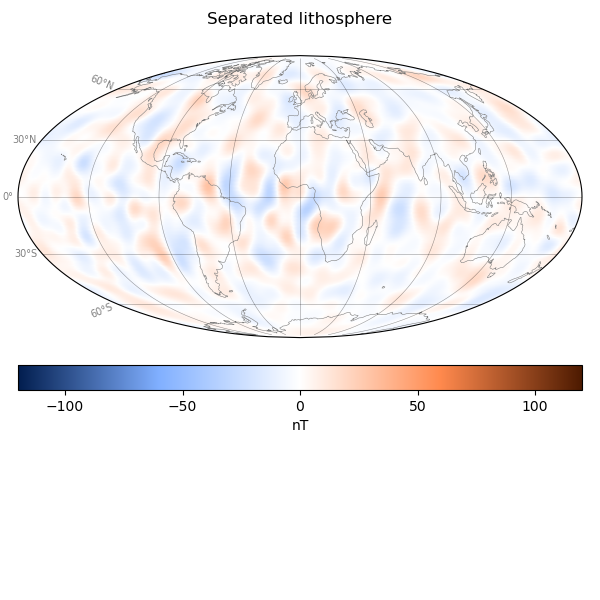

<IPython.core.display.Javascript object>


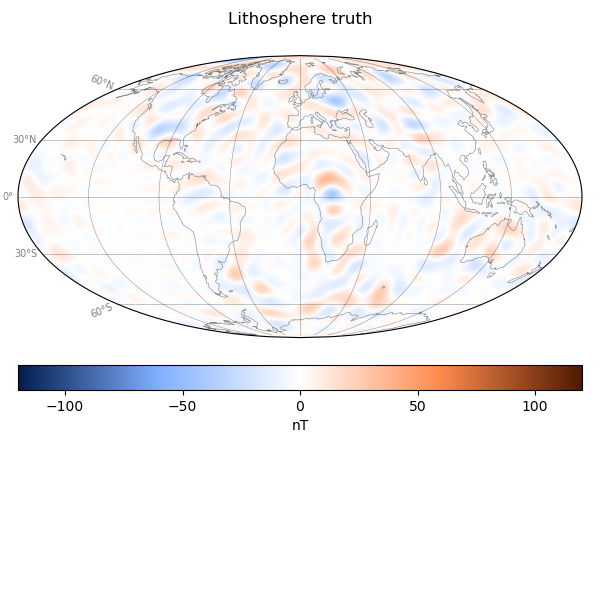

In [56]:
mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=m_lsq_lith, limits_data = [-120,120],
                cbar_h = 0.075, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Separated lithosphere', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=m_lith_truth, limits_data = [-120,120],
                cbar_h = 0.075, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Lithosphere truth', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

lith.grid_glq(nmax = set_nmax_lith, r_at = lith.a)
lith_truth.grid_glq(nmax = set_nmax_lith, r_at = lith_truth.a)

# SDSSIM

In [60]:
lith.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = lith.C_ens_tap)
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

G = np.hstack((core.G,lith.G))
C_dm_all = np.vstack((core.C_dm_all,lith.C_dm_all))

C_mm_all = np.zeros((G.shape[1],G.shape[1]))
C_mm_all[:core.C_mm_all.shape[0],:core.C_mm_all.shape[0]] = core.C_mm_all
C_mm_all[-lith.C_mm_all.shape[0]:,-lith.C_mm_all.shape[0]:] = lith.C_mm_all

#C_e = np.diag(C_e_const**2*np.ones(s_sat.grid_N,))
#C_dd = core.C_dd + lith.C_dd

<IPython.core.display.Javascript object>


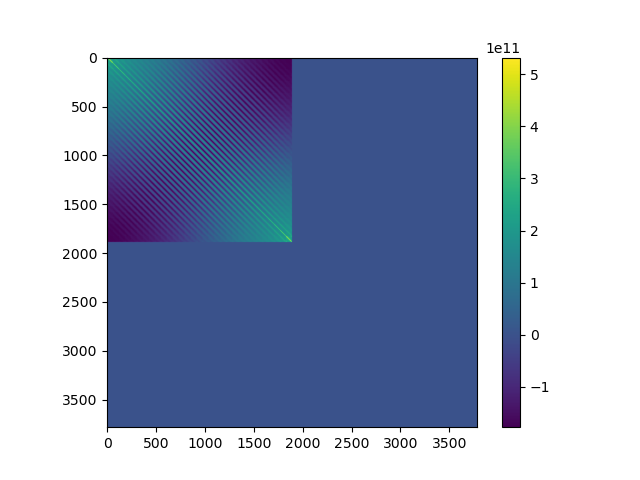

In [61]:
plt.figure()
plt.imshow(C_mm_all)
plt.colorbar()
plt.show()

In [9]:
separation = SDSS(comment)

In [ ]:
N_sim = 1
separation.target_var = np.max(C_mm_all)
separation.target_mean = 0.0
N_m = core.N_grid + lith.N_grid
training_image = np.hstack((core.data,lith.data))
C_dd = [core.C_dd+lith.C_dd, core.C_dd+lith.C_dd]

separation.run_sim(N_sim, N_m, C_mm_all, C_dd, C_dm_all, G,
                   s_sat.data, training_image, collect_all = False, save_string = nb_name, 
                   solve_cho = True, sim_stochastic = False, 
                   separation = True, separation_lim = core.N_grid, 
                   separation_obj_1 = core, separation_obj_2 = lith)

 |OOO-------| 30.8%   realization nr. 0. Counter: 1163/3782

In [80]:
C_vm_all = np.zeros((s_sat.N_grid+core.N_grid+lith.N_grid, s_sat.N_grid+core.N_grid+lith.N_grid))

C_vm_all[:C_dd[0].shape[0],:C_dd[0].shape[0]] = C_dd[0]+C_dd[1]
C_vm_all[-C_mm_all.shape[0]:,-C_mm_all.shape[0]:] = C_mm_all

C_vm_all[-C_mm_all.shape[0]:,:C_dd[0].shape[0]] = C_dm_all
C_vm_all[:C_dd[0].shape[0],-C_mm_all.shape[0]:] = C_dm_all.T
C_vm_all.shape

(6555, 6555)

In [81]:
import scipy.linalg as spl
eigval_vm_1 = spl.eigh(C_vm_all, eigvals_only=True)

In [82]:
eigval_vm_2 = spl.eigh(C_vm_all, eigvals_only=True)

In [83]:
eigval_mm = spl.eigh(C_mm_all, eigvals_only=True)
eigval_dd_1 = spl.eigh(C_dd[0], eigvals_only=True)
eigval_dd_2 = spl.eigh(C_dd[1], eigvals_only=True)

<IPython.core.display.Javascript object>


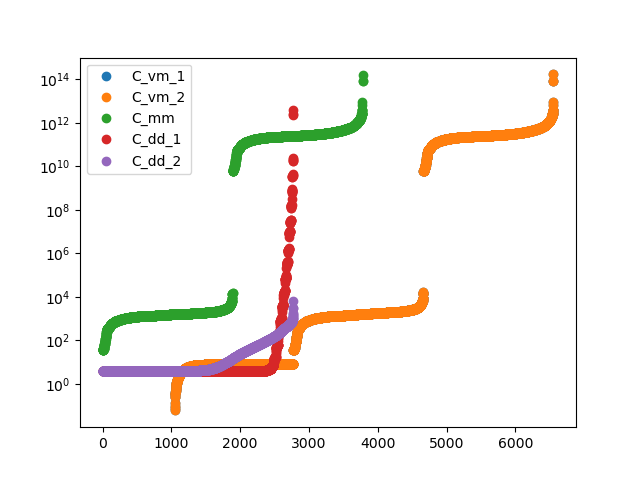

In [84]:
plt.figure()
plt.semilogy(eigval_vm_1,'o',label="C_vm_1")
plt.semilogy(eigval_vm_2,'o',label="C_vm_2")
plt.semilogy(eigval_mm,'o',label="C_mm")
plt.semilogy(eigval_dd_1,'o',label="C_dd_1")
plt.semilogy(eigval_dd_2,'o',label="C_dd_2")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


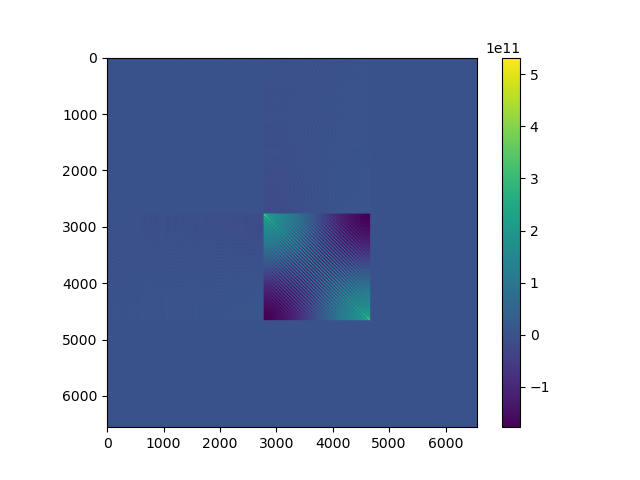

In [68]:
plt.figure()
plt.imshow(C_vm_all)
plt.colorbar()
plt.show()

In [41]:
mt_util.is_pos_def(C_vm_all)

False

<IPython.core.display.Javascript object>


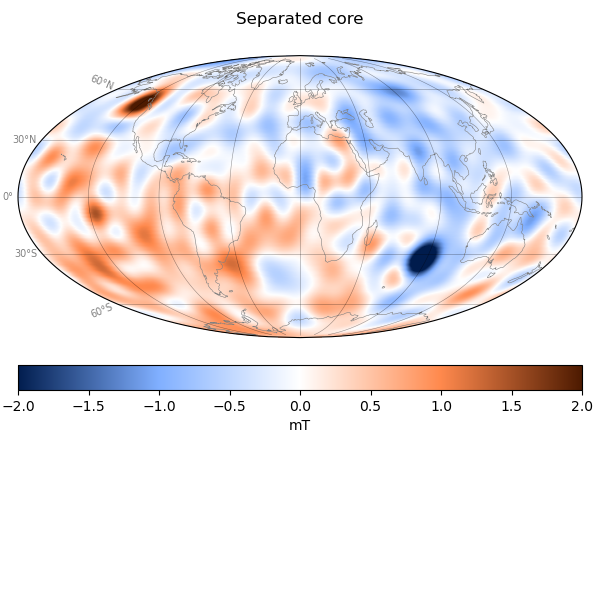

<IPython.core.display.Javascript object>


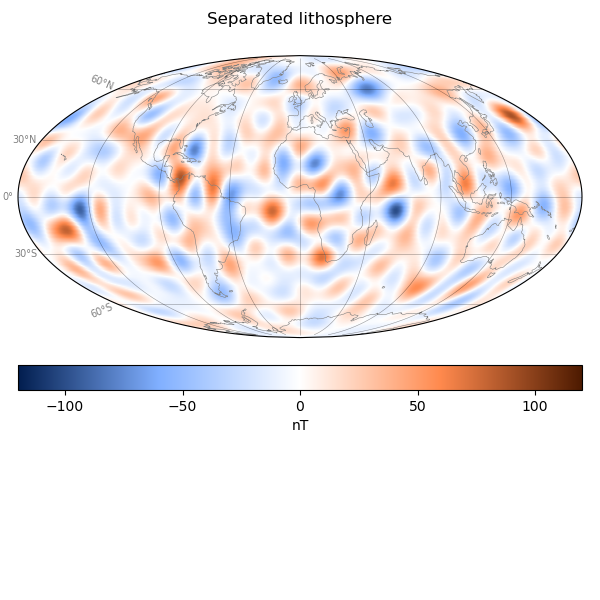

In [12]:
set_nmax_core = 30
set_nmax_lith = 30

core.grid_glq(nmax = set_nmax_core, r_at = core.r_cmb)
lith.grid_glq(nmax = set_nmax_lith, r_at = lith.a)

g_core, _ = mt_util.sh_expand_glq(separation.m_DSS[:core.grid_N], core.grid_nmax, core.grid_w_shtools, 
                                      core.grid_zero, set_nmax_core, geomag_r_at = core.r_cmb)

g_lith, _ = mt_util.sh_expand_glq(separation.m_DSS[core.grid_N:], lith.grid_nmax, lith.grid_w_shtools, 
                                      lith.grid_zero, set_nmax_lith, geomag_r_at = lith.a)

core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(g_core, nmax = set_nmax_core, r_at = core.r_cmb, grid_type = "glq")
m_core = core.B_ensemble[:,0].copy()

lith.grid_glq(nmax = 256, r_at = lith.a)
lith.ensemble_B(g_lith, nmax = set_nmax_lith, r_at = lith.a, grid_type = "glq")
m_lith = lith.B_ensemble[:,0].copy()


mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=m_core, limits_data = [-2,2],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Separated core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_core",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=m_lith, limits_data = [-120,120],
                cbar_h = 0.075, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Separated lithosphere', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.grid_glq(nmax = set_nmax_core, r_at = core.r_cmb)
lith.grid_glq(nmax = set_nmax_lith, r_at = lith.a)

In [ ]:
lith.realization_to_sh_coeff(lith.r_cmb, set_nmax = shc_grid)

In [ ]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

lith.grid_glq(nmax = shc_grid, r_at = lith.a)
mt_util.plot_sdssim_reproduce(lith, lith.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = lith.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = .5, label_fontsize = "small",
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True, ens_prior = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = False, hist_density = True,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_lith_synthetic", save_dpi = 300)

In [12]:
#core.pickle_save_self(nb_name)


Saving job

Job saved and finished


In [13]:
#core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)
core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

In [ ]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1, cbar_limit = [-1.6,1.6],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_synthetic", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
